# 🤪 Variational Autoencoders - CelebA Faces

In this notebook, we'll walk through the steps required to train your own variational autoencoder on the CelebA faces dataset

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

from scipy.stats import norm
import pandas as pd

from notebooks.utils import sample_batch, display

from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

## 0. Parameters <a name="parameters"></a>

In [2]:
IMAGE_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

## 1. Prepare the data <a name="prepare"></a>

In [24]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "..\\..\\..\\data\\img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 498 files belonging to 1 classes.


In [9]:
# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img


train = train_data.map(lambda x: preprocess(x))

In [10]:
train_sample = sample_batch(train)

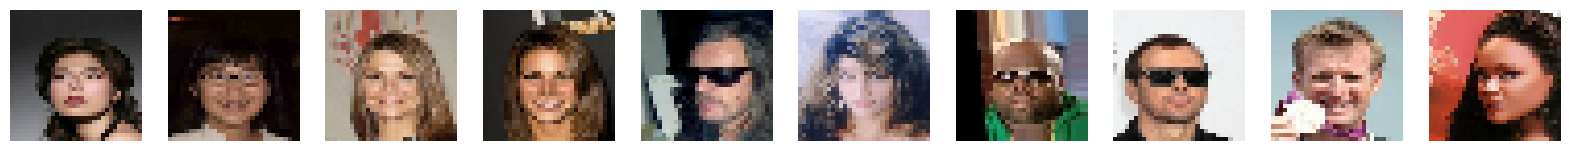

In [11]:
# Show some faces from the training set
display(train_sample, cmap=None)

## 2. Build the variational autoencoder <a name="build"></a>

In [12]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [13]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 128)  3584        ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 128)  512        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 16, 16, 128)  0           ['batch_normalization[0][0]

In [14]:
# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 512)               102912    
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 128)        147584    
 nspose)                                                     

In [15]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [16]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

## 3. Train the variational autoencoder <a name="train"></a>

In [17]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [18]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./output/generated_img_%03d_%d.png" % (epoch, i))

In [19]:
# Load old weights if required
if LOAD_MODEL:
    vae.load_weights("./models/vae")
    tmp = vae.predict(train.take(1))

In [20]:
vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/10
4/4 [==============================] - ETA: 0s - loss: 357.1348 - reconstruction_loss: 238.6514 - kl_loss: 86.4026

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


4/4 [==============================] - 23s 6s/step - loss: 350.7186 - reconstruction_loss: 238.6514 - kl_loss: 86.4026
Epoch 2/10
4/4 [==============================] - ETA: 0s - loss: 234.6569 - reconstruction_loss: 182.5642 - kl_loss: 39.6708

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


4/4 [==============================] - 19s 6s/step - loss: 232.1725 - reconstruction_loss: 182.5642 - kl_loss: 39.6708
Epoch 3/10
4/4 [==============================] - ETA: 0s - loss: 178.3365 - reconstruction_loss: 143.7419 - kl_loss: 27.4911

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


4/4 [==============================] - 21s 7s/step - loss: 176.9158 - reconstruction_loss: 143.7419 - kl_loss: 27.4911
Epoch 4/10
4/4 [==============================] - ETA: 0s - loss: 146.4980 - reconstruction_loss: 124.5508 - kl_loss: 20.0995

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


4/4 [==============================] - 19s 6s/step - loss: 146.1285 - reconstruction_loss: 124.5508 - kl_loss: 20.0995
Epoch 5/10
4/4 [==============================] - ETA: 0s - loss: 130.5572 - reconstruction_loss: 110.9155 - kl_loss: 18.0819

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


4/4 [==============================] - 16s 5s/step - loss: 130.2453 - reconstruction_loss: 110.9155 - kl_loss: 18.0819
Epoch 6/10
4/4 [==============================] - ETA: 0s - loss: 121.0821 - reconstruction_loss: 102.1083 - kl_loss: 17.5789

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


4/4 [==============================] - 14s 4s/step - loss: 120.8032 - reconstruction_loss: 102.1083 - kl_loss: 17.5789
Epoch 7/10
4/4 [==============================] - ETA: 0s - loss: 114.4953 - reconstruction_loss: 98.0663 - kl_loss: 16.0939

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


4/4 [==============================] - 13s 4s/step - loss: 114.4283 - reconstruction_loss: 98.0663 - kl_loss: 16.0939
Epoch 8/10
4/4 [==============================] - ETA: 0s - loss: 110.8340 - reconstruction_loss: 93.8302 - kl_loss: 16.4870

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


4/4 [==============================] - 15s 5s/step - loss: 110.7306 - reconstruction_loss: 93.8302 - kl_loss: 16.4870
Epoch 9/10
4/4 [==============================] - ETA: 0s - loss: 107.7538 - reconstruction_loss: 90.9973 - kl_loss: 15.4809

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


4/4 [==============================] - 19s 6s/step - loss: 107.4987 - reconstruction_loss: 90.9973 - kl_loss: 15.4809
Epoch 10/10
4/4 [==============================] - ETA: 0s - loss: 105.8131 - reconstruction_loss: 89.2019 - kl_loss: 14.8924

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


4/4 [==============================] - 15s 5s/step - loss: 105.4693 - reconstruction_loss: 89.2019 - kl_loss: 14.8924


In [21]:
# Save the final models
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

INFO:tensorflow:Assets written to: ./models/vae\assets


INFO:tensorflow:Assets written to: ./models/vae\assets


INFO:tensorflow:Assets written to: ./models/encoder\assets


INFO:tensorflow:Assets written to: ./models/encoder\assets


INFO:tensorflow:Assets written to: ./models/decoder\assets


INFO:tensorflow:Assets written to: ./models/decoder\assets


## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

In [22]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

4/4 [==============================] - 1s 137ms/step
Example real faces


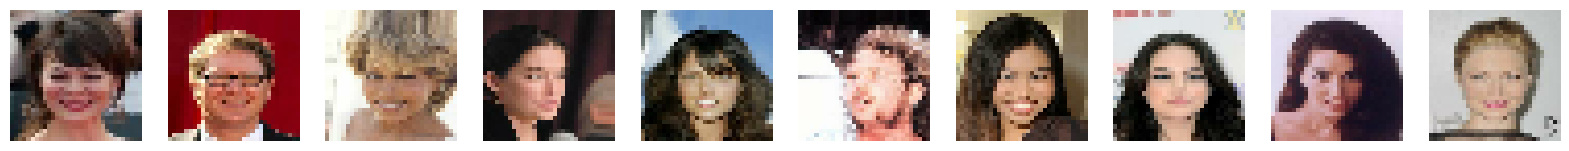

Reconstructions


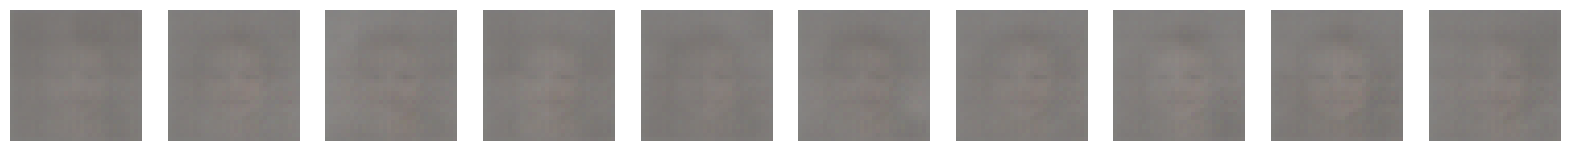

In [23]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
display(example_images)
print("Reconstructions")
display(reconstructions)

## 4. Latent space distribution

In [ ]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

## 5. Generate new faces <a name="decode"></a>

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [ ]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

In [ ]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])

## 6. Manipulate the images <a name="manipulate"></a>

In [ ]:
# Load the label dataset
attributes = pd.read_csv("/app/data/celeba-dataset/list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

In [ ]:
# Load the face data with label attached
LABEL = "Blond_Hair"  # <- Set this label
labelled_test = utils.image_dataset_from_directory(
    "/app/data/celeba-dataset/img_align_celeba",
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

labelled = labelled_test.map(lambda x, y: (preprocess(x), y))

In [ ]:
# Find the attribute vector
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)

In [ ]:
# Add vector to images
add_vector_to_images(labelled, vae, attribute_vec)

In [ ]:
morph_faces(labelled, vae)